<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Regression/regression_model_evaluation_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Model Validation

Zia Ahmed, University at Buffalo

Validation of regression models is a critical step in the model building process to ensure that the model is accurate and reliable. It is important to validate models to ensure that they can make accurate predictions on new, unseen data.

1.  Holdout validation: This technique involves splitting the data into a training set and a validation set. The model is trained on the training set, and its performance is evaluated on the validation set.

2.  Cross-validation: This technique involves splitting the data into multiple folds, training the model on one fold, and testing it on the remaining folds. This process is repeated multiple times, and the results are averaged to get a more accurate estimate of model performance.

3.  Bootstrap validation: This technique involves creating multiple bootstrap samples of the data and using each sample to train and test the model. The results are averaged to get a more accurate estimate of model performance.

4.  Randomized validation: This technique involves randomly splitting the data into training and validation sets multiple times and evaluating the model's performance on each split. The results are averaged to get a more accurate estimate of model performance.

### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314931 sha256=8a9eb18c651aa3ee1659207cceb53c21d5d79aa6479dc9987749a3d85ae29cad
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install R-Packages

In [ ]:
%%R
install.packages(c('tidyverse', 'Metrics', 'ggpmisc', 'broom', 'stargazer',
                   'report', 'performance', 'see', 'jtools', 'relaimpo', 'MASS', 'leap', 'caret' ),
                    lib='drive/My Drive/R/', repos='http://cran.rstudio.com/')

In [ ]:
%%R
install.packages(c('tidymodels'), lib='drive/My Drive/R/', repos='http://cran.rstudio.com/')

### Load Packagess

In [7]:
%%R
.libPaths('drive/My Drive/R')
library(tidyverse)
library(broom)
library(stargazer)
library(report)
library(performance)
library(Metrics)
library(ggpmisc)
library(jtools)
library(relaimpo)
library(MASS)
library(leaps)
library(caret)
library(tidymodels)
# library(caret)



### Data

In this exercise we will use [gp_soil_data_na.csv](https://www.dropbox.com/s/9ikm5yct36oflei/gp_soil_data.csv?dl=0) data set.

In [8]:
%%R
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data.csv"
mf<-read_csv(url(urlfile))
# create a data-frame
df<- mf %>% dplyr::select(SOC, DEM, Slope, MAT, MAP,NDVI, NLCD)


Rows: 467 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD, FRG
dbl (15): ID, FIPS, STATE_ID, Longitude, Latitude, SOC, DEM, Aspect, Slope, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Holdout validation

Holdout validation is used to evaluate the performance of a regression model. It involves splitting the available dataset into two parts: a training set and a validation or test set. The model is trained on the training set, and its performance is evaluated on the validation set. The validation set is usually a randomly selected subset of the original dataset that was not used during training.

The holdout validation technique helps to prevent overfitting, which is a common problem where the model becomes too complex and fits the training data too well, resulting in poor generalization to new data. By using a separate validation set, we can get an estimate of the model's performance on new, unseen data and adjust its parameters or architecture to improve its generalization.

To do so, the basic strategy is to:

1.  Split data - training and validation or test data

2.  Build the model on a training data set

3.  Apply the model on a new test data set to make predictions

4.  Model Evaluation

#### Split Data

We use \*rsample" package to split data into training (70%) and test data (30%) set with Stratified Random Sampling. initial_split() creates a single binary split of the data into a training set and testing set.

**Stratified random sampling** is a technique for selecting a representative sample from a population, where the sample is chosen in a way that ensures that certain subgroups within the population are adequately represented in the sample.

In [9]:
%%R
set.seed(1245)   # for reproducibility
df_split <- initial_split(df, prop = 0.70, strata = NLCD)

df_train <- training(df_split)
df_test  <- testing(df_split)

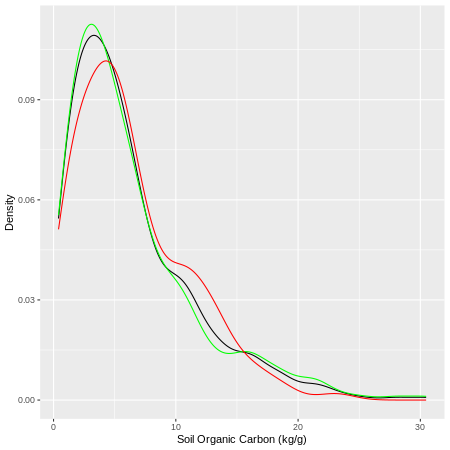

In [12]:
%%R -w 450 -h 450 -u px
# Desnsity plot all, train and test data
ggplot()+
  geom_density(data = df, aes(SOC))+
  geom_density(data = df_train, aes(SOC), color = "green")+
  geom_density(data = df_test, aes(SOC), color = "red") +
      xlab("Soil Organic Carbon (kg/g)") +
      ylab("Density")

#### Training the model

We will train a MLR model with selected predictors:

In [13]:
%%R
# Build the model
model <- lm(SOC ~., data = df_train)
summary(model)


Call:
lm(formula = SOC ~ ., data = df_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.6734  -2.1107  -0.3629   1.5035  16.1818 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             6.8788435  2.9917952   2.299 0.022143 *  
DEM                    -0.0012209  0.0007619  -1.602 0.110048    
Slope                   0.1351551  0.0778406   1.736 0.083484 .  
MAT                    -0.4057325  0.1032154  -3.931 0.000104 ***
MAP                     0.0073889  0.0018703   3.951 9.62e-05 ***
NDVI                    5.7768657  2.7201779   2.124 0.034471 *  
NLCDHerbaceous         -1.8260715  0.9712617  -1.880 0.061014 .  
NLCDPlanted/Cultivated -2.8156619  1.1251168  -2.503 0.012835 *  
NLCDShrubland          -2.2404223  0.9175233  -2.442 0.015162 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.878 on 316 degrees of freedom
Multiple R-squared:  0.4722,	Adjusted R-squared:  

#### Make Prediction

We will use predict() function to predict SOC on test locations.

In [14]:
%%R
df_test$Pred.SOC <- model %>% predict(df_test)

#### Model Evaluation

We will use **Metrics** package to compute several metrics to evaluate the model. All functions in the Metrics package take at least two arguments: **actual** and **predicted**.

Following metrices can be calculated using Metrics packages. It is recommended to use multiple evaluation metrics to assess the performance of the regression model as each metric provides a different perspective on the model's accuracy.

In [15]:
%%R
RMSE<- Metrics::rmse(df_test$SOC, df_test$Pred.SOC)
RMSE

[1] 3.739934


In [16]:
%%R
MAE<- Metrics::mae(df_test$SOC, df_test$Pred.SOC)
MAE

[1] 2.711196


We can plot observed and predicted values with fitted regression line with ggplot2

`geom_smooth()` using formula = 'y ~ x'


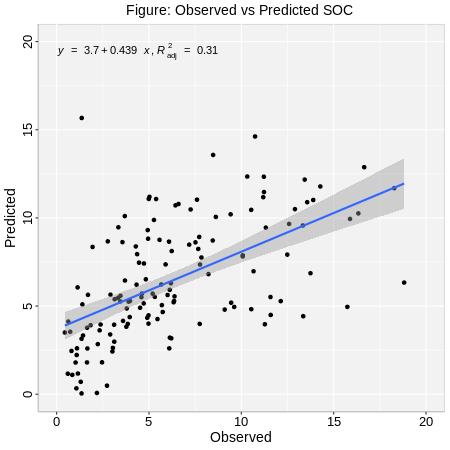

In [17]:
%%R -w 450 -h 450 -u px
formula<-y~x

ggplot(df_test, aes(SOC,Pred.SOC)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Figure: Observed vs Predicted SOC ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,20), breaks=seq(0, 20, 5))+
  scale_y_continuous(limits=c(0,20), breaks=seq(0, 20, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

### Cross Validation

Cross-validation is a technique used to assess the performance and generalizability of a model. The basic idea is to split the data into several subsets, or folds, and use each subset in turn to evaluate the model trained on the remaining data.

Three major types of cross-validation techniques are usually use for model evaluation:

-   k-fold Cross Validation

-   Repeated k-fold Cross Validation

-   Leave One Out Cross Validation

#### K-fold Cross Validation

The most common form of cross-validation is k-fold cross-validation, in which the data is divided into k non-overlapping folds of roughly equal size. The model is then trained on k-1 of the folds and evaluated on the remaining fold. This process is repeated k times, with each fold used as the validation set exactly once. The performance of the model is typically assessed by averaging the evaluation results across the k folds.

To perform cross-validation using the **caret** package, one can use the trainControl() function to specify the details of the cross-validation procedure, such as the number of folds and the type of resampling. Then, the train() function can be used to fit a model using the specified cross-validation procedure.

In [18]:
%%R
# Define training control
set.seed(123)
train.control <- trainControl(method = "cv", number = 10)
# Train the model
model.kfcv <- caret::train(SOC ~., data = df_train,
                           method = "lm",
                          trControl = train.control)
# Summarize the results
print(model.kfcv)

Linear Regression 

325 samples
  6 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 292, 292, 292, 293, 293, 293, ... 
Resampling results:

  RMSE      Rsquared   MAE   
  3.878269  0.4431111  2.8183

Tuning parameter 'intercept' was held constant at a value of TRUE


#### Repeated k-fold Cross Validation

It is similar to k-fold cross-validation, but the process is repeated multiple times with different random splits of the data. In k-fold cross-validation, the data is divided into k equally sized folds, and the model is trained and tested k times, with each fold being used once as the testing data and the remaining folds as training data. The average of these k performance measures is then used as an estimate of the model's performance.

The following example uses 10-fold cross validation with 3 repeats:

In [19]:
%%R
set.seed(123)
train.control <- trainControl(method = "repeatedcv",
                              number = 10, repeats = 5)
# Train the model
model.rkfcv <- train(SOC ~., data = df_train, method = "lm",
               trControl = train.control)
# Summarize the results
print(model.rkfcv)

Linear Regression 

325 samples
  6 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 292, 292, 292, 293, 293, 293, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  3.902973  0.4660419  2.824213

Tuning parameter 'intercept' was held constant at a value of TRUE


#### Leave One Out Cross Validation or LOOCV

Leave One Out Cross Validation (LOOCV) is a type of cross-validation method used in statistical analysis and machine learning to evaluate the performance of a model. In LOOCV, the data is split into training and testing sets in such a way that each observation is used as a testing sample exactly once.

The LOOCV process involves removing one observation from the data set and training the model on the remaining n-1 observations. The removed observation is then used as the test set, and the performance of the model is evaluated on this single observation. This process is repeated for each observation in the data set, resulting in n performance measures. The average of these performance measures is then used as an estimate of the model's performance.

The advantage of the **LOOCV** method is that we make use all data points reducing potential bias. However, the process is repeated as many times as there are data points, resulting to a higher execution time when n is extremely large.

In [20]:
%%R
# Define training control
train.control <- trainControl(method = "LOOCV")
# Train the model
model.loocv <- train(SOC ~., data = df_train, method = "lm",
               trControl = train.control)
# Summarize the results
print(model.loocv)

Linear Regression 

325 samples
  6 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 324, 324, 324, 324, 324, 324, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  3.952533  0.4370173  2.828391

Tuning parameter 'intercept' was held constant at a value of TRUE


### Bootstrap validation

Bootstrap validation is a resampling technique used to estimate the uncertainty of a model's performance.

In [21]:
%%R
# Define training control
train.control <- trainControl(method = "boot", number = 100)
# Train the model
model.boot <- train(SOC ~., data = df_train, method = "lm",
               trControl = train.control)
# Summarize the results
print(model.boot)

Linear Regression 

325 samples
  6 predictor

No pre-processing
Resampling: Bootstrapped (100 reps) 
Summary of sample sizes: 325, 325, 325, 325, 325, 325, ... 
Resampling results:

  RMSE    Rsquared   MAE     
  4.0037  0.4227783  2.871766

Tuning parameter 'intercept' was held constant at a value of TRUE
